# Chapter 1. Neural encoding I: Firing rates and spike statistics

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.integrate import odeint
%matplotlib notebook
plt.style.use('seaborn-whitegrid')

## Task 1
Generate spikes for 10 s (or longer if you want better statistics) using
a Poisson spike generator with a constant rate of 100 Hz, and record
their times of occurrence. Compute the coefficient of variation of the
interspike intervals, and the Fano factor for spike counts obtained
over counting intervals ranging from 1 to 100 ms. Plot the interspike
interval histogram.

## Useful functions

In [117]:
def HomogeneousPoisson(rate, duration, dt=1e-6):
    '''
    Homogeneous Poisson process spike generator, 
    implemented by dividing time into bins and calculating
    prob. of spike generation.
    
    Return: array with spike times
    '''
    NoBins = int(duration/dt)
    time = np.random.uniform(0, 1, NoBins)
    
    # choose elements that have x_rand less than prob. of firing a spike
    spikes = np.nonzero(rate * dt > time)

    # normalize indices in order to be consistent with time
    spikes = (np.array(spikes) / NoBins) * duration
    
    return spikes.flatten()

def HomogeneousPoisson2(rate, duration):
    '''
    Homogeneous Poisson process spike generator,
    implemented by calculating interspike intervals.
    
    Return: array with spike times
    '''
    spikes = [0]
    
    while spikes[-1] < duration:
        spikes.append(spikes[-1] - np.log(np.random.rand()) / rate)
    return np.array(spikes[1:-1])

def ISI_spike_counts(spikes_times, step_interval=100, binwidth=1, plot=False):
    spikes_counts = []
    step_interval /= 1000 # converts to seconds
    start = 0
    end = step_interval
    while end <= np.max(spikes_times):
        spikes_counts.append( len(spikes_times[ (spikes_times > start) & (spikes_times <= end) ]) )
        start += step_interval
        end += step_interval
    if plot:
        plt.figure(dpi=100)
        plt.hist(spikes_counts, bins='auto', 
             color='purple', ec='black')
        plt.xlabel('no. of spikes')
    else:
        return spikes_counts
    

def fano(data):
    '''
    Computes Fano's factor for different intervals
    over which spikes are counted.
    duration/interval = no. of counts
    F = Var(data)/mean(data)
    '''
    fanos = []
    data = np.array(data)
    for t in range(1, 100): # ms
        T_sec = t / 1000 # convert to seconds
        start = 0 # seconds
        end = T_sec # seconds
        spikes_counts = []
        while end <= np.max(data):
            spikes_counts.append( len(data[ (data > start) & (data <= end) ]) )
            start += T_sec
            end += T_sec
        fanos.append( np.var(spikes_counts)/np.mean(spikes_counts) )
        
    return fanos

def coefficient_variation(data):
    '''
    Calculates coefficinet of variation
    C_V = std(data) / mean(data)
    '''
    return np.std(data) / np.mean(data)

Fixing the problem with Fano factors

In [84]:
spikes = HomogeneousPoisson2(100, 10)
print('Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)')
print(fano(spikes)[0])

Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)
1.0041176102989047


In [85]:
m = HomogeneousPoisson(100, 100)
m2 = HomogeneousPoisson2(100, 100)

#plt.vlines(m, 0, 1)
#plt.vlines(m2, 0, 1)
#plt.title('Spike Train', loc='left')

## ISI (interspike intervals) distribution (density)

<IPython.core.display.Javascript object>


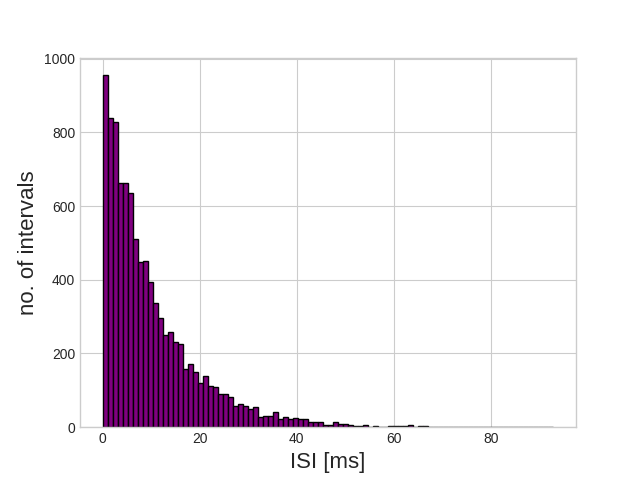

Text(0, 0.5, 'no. of intervals')

In [103]:
plt.figure(dpi=100)
isi = np.diff(m) *1000
plt.hist(isi, bins='auto', color='purple', ec='black')
plt.xlabel('ISI [ms]', fontsize=16)
plt.ylabel('no. of intervals', fontsize=16)

## Spike counts distribution
Firing rate 100 Hz

<IPython.core.display.Javascript object>


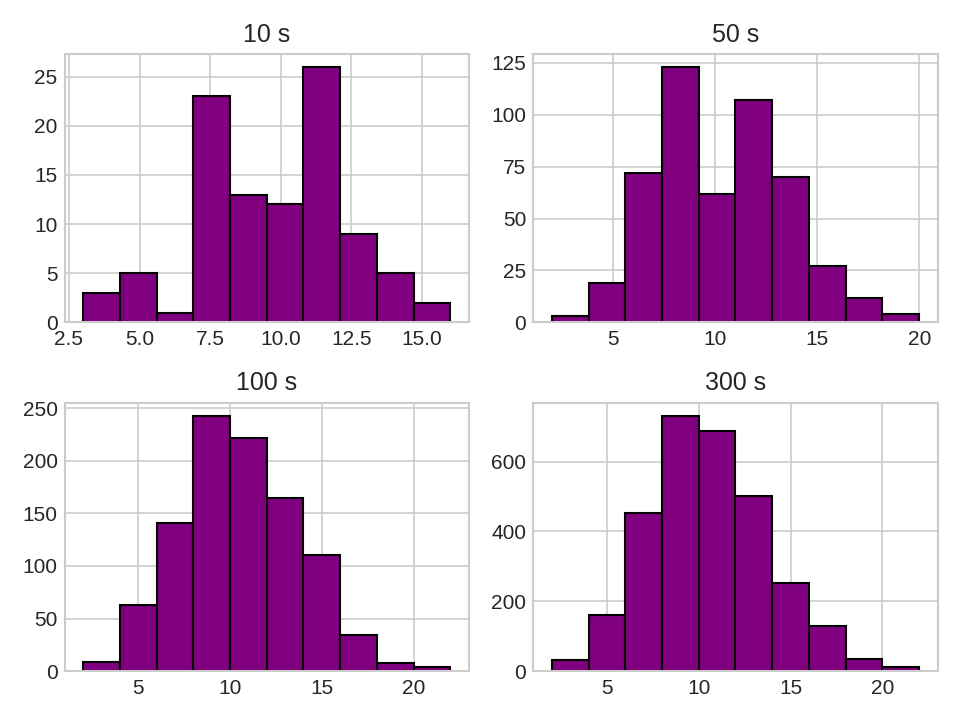

In [125]:
spikes = HomogeneousPoisson2(100, 600)
ISI_spike_counts(spikes)

fig, axs = plt.subplots(2, 2)
fig.dpi=150
axs[0, 0].hist( ISI_spike_counts(HomogeneousPoisson2(100, 10)), color='purple', ec='black')
axs[0, 0].set_title('10 s')
axs[0, 1].hist( ISI_spike_counts(HomogeneousPoisson2(100, 50)), color='purple', ec='black' )
axs[0, 1].set_title('50 s')
axs[1, 0].hist( ISI_spike_counts(HomogeneousPoisson2(100, 100)), color='purple', ec='black' )
axs[1, 0].set_title('100 s')
axs[1, 1].hist( ISI_spike_counts(HomogeneousPoisson2(100, 300)), color='purple', ec='black' )
axs[1, 1].set_title('300 s')
plt.tight_layout()

As can be seen, for larger simulation times, distribution of counter spikes approaches normal distribution

## Compute the coefficient of variation ($C_V$) of ISI

In [75]:
cv = coefficient_variation(isi)
print('Coefficient of variation: %s' % cv)

Coefficient of variation: 1.01183762219128


## Compute the coefficient of variation ($C_V$) and fano factor for spike counts

In [70]:
cv = coefficient_variation(m)
print('Coefficient of variation: %s' % cv)

fano_factor = fano(m)
print('Fano factor: %s' % fano_factor[0])

Coefficient of variation: 0.5824769983810014
Fano factor: 1.0002691327266218


## Task 2

Add a refractory period to the Poisson spike generator by allowing
the firing rate to depend on time. Initially, set the firing rate to a
constant value, $r(t) = r_0 $. After every spike, set $r(t)$ to 0, and then
allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$
that controls the refractory recovery rate. In other words, have $r(t)$
obey the equation

$$
\tau_{ref} \frac{dr}{dt} = r_0 - r
$$

except immediately after a spike, when it is set to 0.

If we solve the above equaition, we will get:
$$
r(t) = r_0 - (r_0 - r_{init})\cdot \exp{\left(-\frac{t}{\tau_{ref}}\right)}
$$